In [1]:
import tensorflow as tf

In [2]:
# Adaptations for running Tensorflow on GeForce RTX 2080
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: GeForce RTX 2080, pci bus id: 0000:02:00.0, compute capability: 7.5



In [3]:
tf.test.is_gpu_available()

True

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [5]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, Conv2DTranspose, Lambda, LeakyReLU, \
ZeroPadding2D
from tensorflow.keras.layers import MaxPooling2D, Dropout, UpSampling2D, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
import PIL
from PIL import Image

In [7]:
import time

In [8]:
""" layer_utils - taken from DeblurGAN implementation
    https://github.com/RaphaelMeudec/deblur-gan """

import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Layer,
    Input,
    Conv2D,
    Activation,
    BatchNormalization,
    Add,
    Dropout,
)
from tensorflow.keras.models import Model


def res_block(input, filters, kernel_size=(3, 3), strides=(1, 1), use_dropout=False):
    """
    Instanciate a Keras Resnet Block using sequential API.
    :param input: Input tensor
    :param filters: Number of filters to use
    :param kernel_size: Shape of the kernel for the convolution
    :param strides: Shape of the strides for the convolution
    :param use_dropout: Boolean value to determine the use of dropout
    :return: Keras Model
    """
    x = ReflectionPadding2D((1, 1))(input)
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if use_dropout:
        x = Dropout(0.5)(x)

    x = ReflectionPadding2D((1, 1))(x)
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,)(x)
    x = BatchNormalization()(x)

    merged = Add()([input, x])
    return merged


def spatial_reflection_2d_padding(x, padding=((1, 1), (1, 1)), data_format=None):
    """
    Pad the 2nd and 3rd dimensions of a 4D tensor.
    :param x: Input tensor
    :param padding: Shape of padding to use
    :param data_format: Tensorflow vs Theano convention ('channels_last', 'channels_first')
    :return: Tensorflow tensor
    """
    assert len(padding) == 2
    assert len(padding[0]) == 2
    assert len(padding[1]) == 2
    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {"channels_first", "channels_last"}:
        raise ValueError("Unknown data_format " + str(data_format))

    pattern = (
        [[0, 0], [0, 0], list(padding[0]), list(padding[1])]
        if data_format == "channels_first"
        else [[0, 0], list(padding[0]), list(padding[1]), [0, 0]]
    )

    return tf.pad(x, pattern, "REFLECT")


class ReflectionPadding2D(Layer):
    """Reflection-padding layer for 2D input (e.g. picture).
    This layer can add rows and columns or zeros
    at the top, bottom, left and right side of an image tensor.
    # Arguments
        padding: int, or tuple of 2 ints, or tuple of 2 tuples of 2 ints.
            - If int: the same symmetric padding
                is applied to width and height.
            - If tuple of 2 ints:
                interpreted as two different
                symmetric padding values for height and width:
                `(symmetric_height_pad, symmetric_width_pad)`.
            - If tuple of 2 tuples of 2 ints:
                interpreted as
                `((top_pad, bottom_pad), (left_pad, right_pad))`
        data_format: A string,
            one of `channels_last` (default) or `channels_first`.
            The ordering of the dimensions in the inputs.
            `channels_last` corresponds to inputs with shape
            `(batch, height, width, channels)` while `channels_first`
            corresponds to inputs with shape
            `(batch, channels, height, width)`.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".
    # Input shape
        4D tensor with shape:
        - If `data_format` is `"channels_last"`:
            `(batch, rows, cols, channels)`
        - If `data_format` is `"channels_first"`:
            `(batch, channels, rows, cols)`
    # Output shape
        4D tensor with shape:
        - If `data_format` is `"channels_last"`:
            `(batch, padded_rows, padded_cols, channels)`
        - If `data_format` is `"channels_first"`:
            `(batch, channels, padded_rows, padded_cols)`
    """

    def __init__(self, padding=(1, 1), data_format=None, **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        self.data_format = data_format
        if isinstance(padding, int):
            self.padding = ((padding, padding), (padding, padding))
        elif hasattr(padding, "__len__"):
            if len(padding) != 2:
                raise ValueError(
                    "`padding` should have two elements. " "Found: " + str(padding)
                )
            height_padding = (
                padding[0]
                if isinstance(padding[0], tuple)
                else (padding[0], padding[0])
            )
            width_padding = (
                padding[1]
                if isinstance(padding[1], tuple)
                else (padding[1], padding[1])
            )
            self.padding = (height_padding, width_padding)
        else:
            raise ValueError(
                "`padding` should be either an int, "
                "a tuple of 2 ints "
                "(symmetric_height_pad, symmetric_width_pad), "
                "or a tuple of 2 tuples of 2 ints "
                "((top_pad, bottom_pad), (left_pad, right_pad)). "
                "Found: " + str(padding)
            )

    def compute_output_shape(self, input_shape):
        if self.data_format == "channels_first":
            if input_shape[2] is not None:
                rows = input_shape[2] + self.padding[0][0] + self.padding[0][1]
            else:
                rows = None
            if input_shape[3] is not None:
                cols = input_shape[3] + self.padding[1][0] + self.padding[1][1]
            else:
                cols = None
            return (input_shape[0], input_shape[1], rows, cols)
        elif self.data_format == "channels_last":
            if input_shape[1] is not None:
                rows = input_shape[1] + self.padding[0][0] + self.padding[0][1]
            else:
                rows = None
            if input_shape[2] is not None:
                cols = input_shape[2] + self.padding[1][0] + self.padding[1][1]
            else:
                cols = None
            return (input_shape[0], rows, cols, input_shape[3])

    def call(self, inputs):
        return spatial_reflection_2d_padding(
            inputs, padding=self.padding, data_format=self.data_format
        )

    def get_config(self):
        config = {"padding": self.padding, "data_format": self.data_format}
        base_config = super(ReflectionPadding2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


if __name__ == "__main__":
    input = Input(shape=(256, 256, 3))
    x = ReflectionPadding2D(3)(input)
    model = Model(input, x)
    model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
reflection_padding2d (Reflec (None, 262, 262, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [9]:
""" Generator model - taken from DeblurGAN implementation
    https://github.com/RaphaelMeudec/deblur-gan """

from tensorflow.keras.layers import (
    Input,
    Activation,
    Add,
    UpSampling2D,
    LeakyReLU,
    Conv2D,
    Dense,
    Flatten,
    Lambda,
    BatchNormalization,
)
from tensorflow.keras.models import Model

#from layer_utils import ReflectionPadding2D, res_block

# TODO: Pass those elements in a config file
# the paper defined hyper-parameter:chr
channel_rate = 64
ngf = 64
ndf = 64
input_nc = 1
output_nc = 1
n_blocks_gen = 9


def make_generator_model(input_shape=(256, 256, 1)):
    """Build generator architecture."""
    # Current version : ResNet block
    inputs = Input(shape=input_shape)

    x = ReflectionPadding2D((3, 3))(inputs)
    x = Conv2D(filters=ngf, kernel_size=(7, 7), padding="valid")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    n_downsampling = 2
    for i in range(n_downsampling):
        mult = 2 ** i
        x = Conv2D(
            filters=ngf * mult * 2, kernel_size=(3, 3), strides=2, padding="same"
        )(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    mult = 2 ** n_downsampling
    for i in range(n_blocks_gen):
        x = res_block(x, ngf * mult, use_dropout=True)

    for i in range(n_downsampling):
        mult = 2 ** (n_downsampling - i)
        x = Conv2DTranspose(filters=int(ngf * mult / 2), kernel_size=(3, 3), strides=2, padding='same')(x)
        x = UpSampling2D()(x)
        x = Conv2D(filters=int(ngf * mult / 2), kernel_size=(3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    x = ReflectionPadding2D((3, 3))(x)
    x = Conv2D(filters=output_nc, kernel_size=(7, 7), padding="valid")(x)
    x = Activation("tanh")(x)

    outputs = Add()([x, inputs])
    outputs = Lambda(lambda z: z / 2)(outputs)

    model = Model(inputs=inputs, outputs=outputs, name="Generator")
    return model

In [10]:
# Training and test parameters
num_train = 20 # number of images used in training
num_test = 1 # number of images used in testing

In [11]:
# Loading data for training
# Images degraded by sigma = 2 and filter dimension = (7, 7) (gaussian blur)

blurred_train = np.zeros((num_train, 256, 256, 1)) # array with degraded images for training
original_train = np.zeros((num_train, 256, 256, 1)) # array with non-degraded images for training

for i in range (1, num_train+1):
    blurred_train[i-1, :, :, 0] = np.load('dataset_gray/sigma2(7, 7)/arrays/degradada' + str(i) + '.npy')
    original_train[i-1, :, :, 0] = np.load('dataset_gray/original/arrays/original' + str(i) + '.npy')

In [12]:
# Normalizing data
blurred_train = blurred_train/(blurred_train.max())
original_train = original_train/(original_train.max())

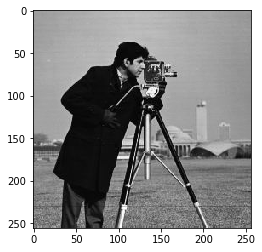

In [13]:
plt.imshow(original_train[0, :, :, 0], cmap='gray')

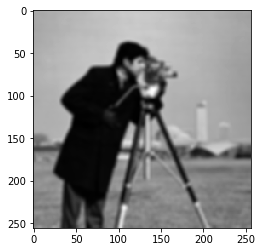

In [14]:
plt.imshow(blurred_train[0, :, :, 0], cmap='gray')

In [15]:
# Converting data to tensor for SSIM comparison (used SSIM function from Tensorflow library)
blurred_train_tf = tf.convert_to_tensor(blurred_train)
original_train_tf = tf.convert_to_tensor(original_train)

In [16]:
# Loading data for testing
# Images degraded by sigma = 2 and dimension = (7, 7) (gaussian blur)

blurred_test = np.zeros((num_test, 256, 256, 1)) # array with degraded images for testing
original_test = np.zeros((num_test, 256, 256, 1)) # array with non-degraded images for testing

blurred_test[0, :, :, 0] = np.load('dataset_gray/sigma2(7, 7)/arrays/degradada.npy')
original_test[0, :, :, 0] = np.load('dataset_gray/original/arrays/original.npy')

In [17]:
# Normalizing data
blurred_test = blurred_test/(blurred_test.max())
original_test = original_test/(original_test.max())

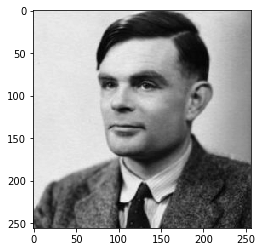

In [18]:
plt.imshow(original_test[0, :, :, 0], cmap='gray')

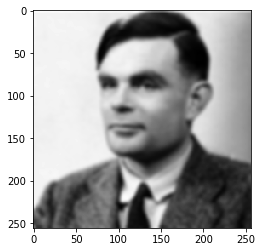

In [19]:
plt.imshow(blurred_test[0, :, :, 0], cmap='gray')

In [20]:
# Converting data to tensor for SSIM comparison (used SSIM function from Tensorflow library)
blurred_test_tf = tf.convert_to_tensor(blurred_test)
original_test_tf = tf.convert_to_tensor(original_test)

In [21]:
# Making generator model
generator = make_generator_model(blurred_test.shape[1:])
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
reflection_padding2d_1 (Reflect (None, 262, 262, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 3200        reflection_padding2d_1[0][0]     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



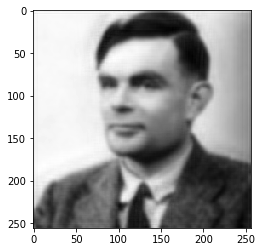

In [22]:
# Output from generator (without any training)
generated_image = generator(blurred_test, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [23]:
# Discriminator model
def make_discriminator_model(input_shape):
    
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [24]:
# Making discriminator
discriminator = make_discriminator_model(generated_image.shape[1:])
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 128, 128, 64)      1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 128)       204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 64, 64, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 524288)            0

In [25]:
# Output from discriminator (without any training)
decision = discriminator(generated_image, training=False)
print (decision)

tf.Tensor([[0.00929999]], shape=(1, 1), dtype=float32)


In [26]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
# Loss for discriminator model
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [28]:
# Loss for generator model
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [29]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [30]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# Defining training step for GAN

@tf.function
def train_step(sharp_images, blurred_images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(blurred_images, training=True)

        real_output = discriminator(sharp_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [31]:
# Function for training
def train(sharp_images, blurred_images, epochs=1000):
    loss = np.zeros(shape=(2, epochs))
    for epoch in range(epochs):
        start = time.time()

        gen, disc = train_step(sharp_images[:10], blurred_images[:10])
        gen, disc = train_step(sharp_images[10:], blurred_images[10:])

        loss[:, epoch] = gen, disc
        print ('Time for epoch {} is {} sec --- Gen. loss: {}; Disc. loss: {}'.format(epoch + 1, time.time()-start, gen, disc))
        
    return loss

In [ ]:
loss = train(original_train, blurred_train, epochs = 10000)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


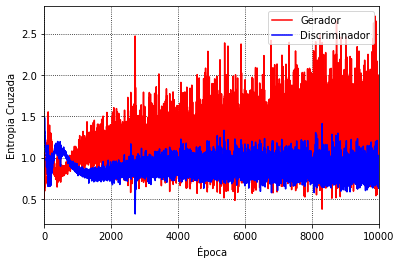

In [46]:
# Plotting losses
plt.plot(loss[0, :], 'r', label='Gerador')
plt.plot(loss[1, :], 'b', label='Discriminador')
plt.legend(loc='upper right')
plt.xlim(0, 10000)
plt.grid(color='black', linestyle='dotted')
plt.ylabel('Entropia Cruzada')
plt.xlabel('Época')
plt.savefig('saved/gan/error.eps', format='eps')
plt.show()

In [47]:
# Saving models
generator.save('saved/gan/generator.h5')
discriminator.save('saved/gan/discriminator.h5')

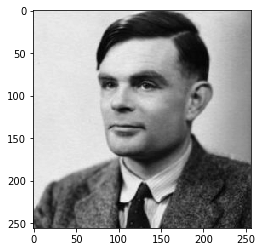

In [64]:
# Original image from training dataset
plt.imshow(original_test_tf[0, :, :, 0], cmap='gray')

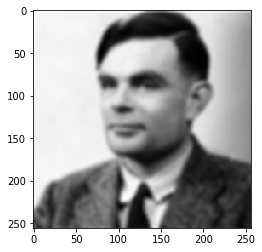

In [65]:
# Degraded image from testing dataset
plt.imshow(blurred_test_tf[0, :, :, 0], cmap='gray')

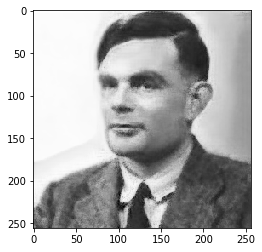

In [63]:
# Restored image by generator
test_prediction = generator.predict(blurred_test)
test_prediction_tf = tf.convert_to_tensor(test_prediction, np.float64)
plt.imshow(test_prediction_tf[0, :, :, 0], cmap='gray')

In [41]:
# SSIM between original and degraded pictures 
tf.image.ssim(original_test_tf[0, :, :, :], blurred_test_tf[0, :, :, :], max_val=1).numpy()

0.8623652

In [67]:
# SSIM between original and restored pictures 
# (note that SSIM for restored image is lower than SSIM for degraded image)
tf.image.ssim(original_test_tf[0, :, :, :], test_prediction_tf[0, :, :, :], max_val=1).numpy()

0.8565614

In [68]:
# PSNR between original and degraded pictures 
tf.image.psnr(original_test_tf[0, :, :, :], blurred_test_tf[0, :, :, :], max_val=1).numpy()

25.521852

In [69]:
# PSNR between original and restored pictures 
tf.image.psnr(original_test_tf[0, :, :, :], test_prediction_tf[0, :, :, :], max_val=1).numpy()

25.60082